In [1]:
import pandas as pd

import tensorflow as tf
import json
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from auxiliary.data.dataset_cell import CellDataset
from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D
from cell_division.nets.custom_layers import (
    w_cel_loss, 
    focal_loss,
    ExtendedLSEPooling,
    extended_w_cel_loss,
    LSEPooling
)

from cell_division.nets.cam import GradCAM, overlay_heatmap, CAM, GradCAMpp

# GPU config
from auxiliary.utils.timer import LoadingBar
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator, 
    clear_session
)

increase_gpu_memory()
set_gpu_allocator()

Create and save images with just the nuclei

In [16]:
# img_dir = v.data_path + 'CellDivision/images/'
# img_out_dir = v.data_path + 'CellDivision/images_nuclei/'
# label_dir = v.data_path + 'CellDivision/data.csv'
# 
# data_generator = CellDataset(
#     img_dir, 
#     label_dir,
#     batch_size=1,
#     resize=(50, 50)
# )
# 
# def format_names(idx):
#     return f'{idx:03}.tif'
# 
# for i, (img, label) in enumerate(data_generator):
#     img = np.uint8(img[0][..., 2] * 255)
#     
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
#     cv2.imwrite(img_out_dir + format_names(i+1), img)


Training

In [2]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 32

In [3]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

Epoch 1/100
13/13 [==============================] - 14s 1s/step - loss: 2.5565 - auc: 0.8093 - val_loss: 1.4141 - val_auc: 0.6638 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 10s 783ms/step - loss: 1.7013 - auc: 0.8804 - val_loss: 1.3143 - val_auc: 0.7710 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 10s 763ms/step - loss: 1.4887 - auc: 0.9049 - val_loss: 1.2987 - val_auc: 0.7712 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 1.2282 - auc: 0.9150
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
13/13 [==============================] - 10s 753ms/step - loss: 1.2282 - auc: 0.9150 - val_loss: 1.3539 - val_auc: 0.7444 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 11s 848ms/step - loss: 0.9861 - auc: 0.9326 - val_loss: 1.2747 - val_auc: 0.7699 - lr: 1.0000e-04
Epoch 6/100
13/13 [==============================] - 10s 805ms/step - loss: 0.9876 - auc: 0.9287 - val_loss: 

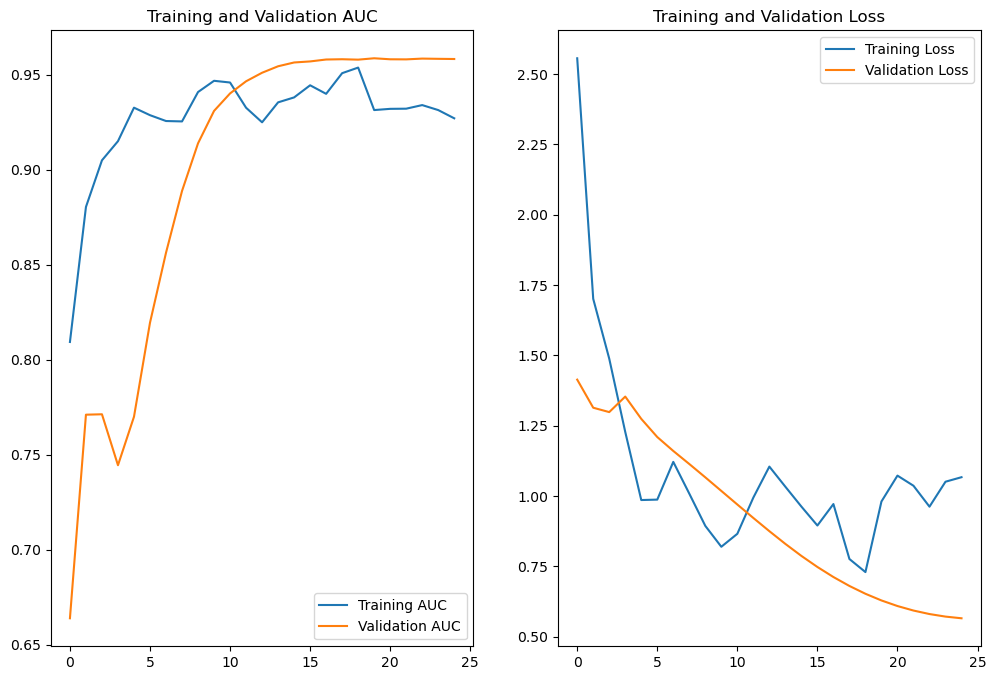

In [9]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)
model.fit(
    train_generator,
    val_generator,
    epochs=100,
    verbose=2,
    batch_size=BATCH_SIZE
)

model.model.save('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [ ]:
# model = CNN()
# model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

In [11]:
results = model.model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 3s 852ms/step - loss: 0.6904 - auc: 0.9435


In [12]:
pred = model.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

                    precision    recall  f1-score   support

Prophase/Metaphase       0.89      0.81      0.85        42
Anaphase/Telophase       0.82      0.86      0.84        42
        Interphase       0.87      0.91      0.89        43

          accuracy                           0.86       127
         macro avg       0.86      0.86      0.86       127
      weighted avg       0.86      0.86      0.86       127



<Figure size 1200x1200 with 0 Axes>

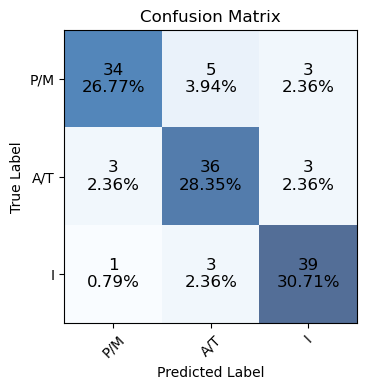

In [13]:
cf_matrix = confusion_matrix(
    test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [14]:
test_generator = CellDataset(
    img_dir, 
    label_test_dir, 
    batch_size=1, 
    resize=INPUT_SHAPE[:2]
)

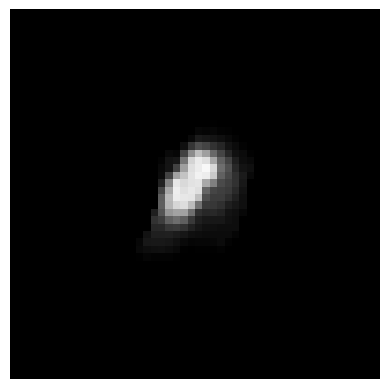

In [39]:
img_idx = 29 # 87 # 44 # 40 # 0  # 98  # 25
test_img_tf = test_generator[img_idx][0]
test_img = test_img_tf.numpy().astype(np.float32)
test_img = test_img.reshape(INPUT_SHAPE)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img); plt.axis('off')
plt.show()

Real label: Prophase/Metaphase
Predicted label: Anaphase/Telophase


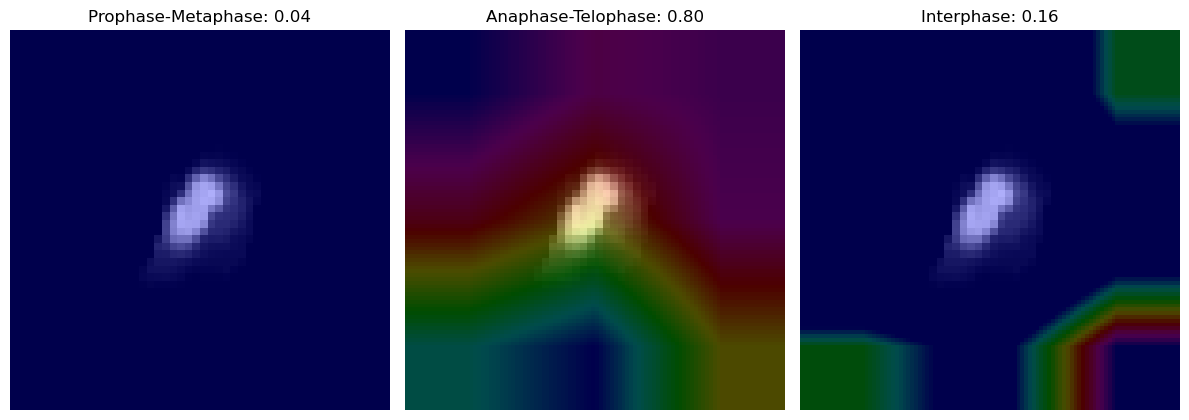

In [40]:
cam = CAM(model.model)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0, normalize=True)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1, normalize=True)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2, normalize=True)

pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()

Real label: Anaphase/Telophase
Predicted label: Anaphase/Telophase


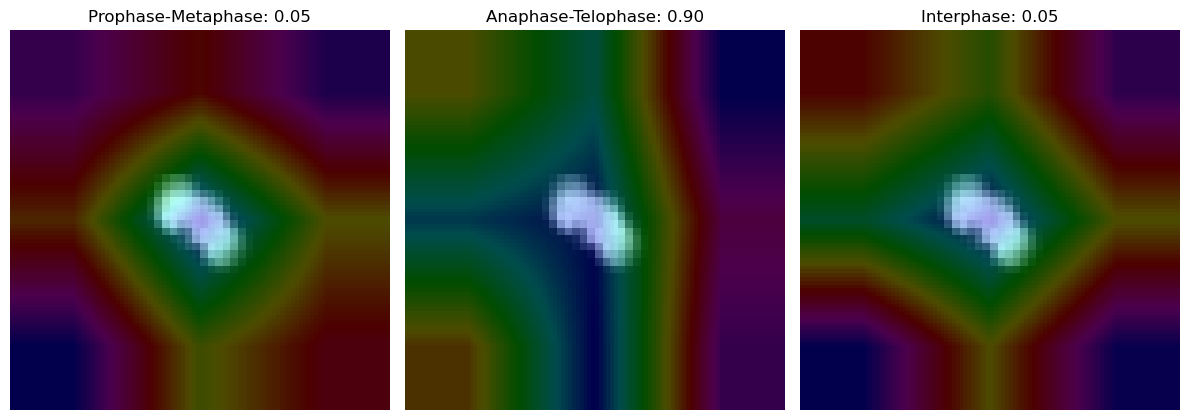

In [25]:
cam = GradCAM(model.model)
heatmap_pm = cam.compute_heatmap(test_img_tf, class_idx=0)
heatmap_at = cam.compute_heatmap(test_img_tf, class_idx=1)
heatmap_i = cam.compute_heatmap(test_img_tf, class_idx=2)

pred = model.model.predict(test_img_tf)
print(f'Real label: {test_generator.oh2name(test_generator[img_idx][1])}')
print(f'Predicted label: {test_generator.oh2name(pred)}')

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(overlay_heatmap(test_img, heatmap_pm, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Prophase-Metaphase: {pred[0][0]:.2f}')

plt.subplot(1, 3, 2)
plt.imshow(overlay_heatmap(test_img, heatmap_at, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Anaphase-Telophase: {pred[0][1]:.2f}')

plt.subplot(1, 3, 3)
plt.imshow(overlay_heatmap(test_img, heatmap_i, alpha=.7, colormap=cv2.COLORMAP_HSV)); plt.axis('off')
plt.title(f'Interphase: {pred[0][2]:.2f}')

plt.tight_layout()
plt.show()